This notebook was made to predict the heights and time for high and low waters in New West, Mission, Sandheads, Deas Island by relating them to the corresponding higher high and lower low water at Point Atkinson and discharge at Hope.

In [1]:
from __future__ import division
from cStringIO import StringIO
from salishsea_tools import (
    nc_tools,
    viz_tools,
    stormtools,
    tidetools,
)
from salishsea_tools.nowcast import figures
from matplotlib import pylab
from dateutil import tz
from matplotlib.backends import backend_agg as backend
from scipy import interpolate as interp
from matplotlib import animation
import scipy.io as sio
import datetime
import glob
import os
import arrow
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import netCDF4 as nc
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import datetime
import arrow
%matplotlib inline

In [2]:
sites = {
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30,
        'i' : 426,
        'j' : 293
   
    },
    'Deas Island':{
        'lat' : 48.12,
        'lon' : -123.07,
        'i' : 414,
        'j' : 328
    },    
    'New Westminster': {
        'lat': 49.21,
        'lon': -122.89,
        'i': 418,
        'j': 365
        },

    'Mission': {
        'lat': 48.59,
        'lon': -123.2,
        'i':  500,
        'j':367
    },


        }

In [3]:
SITES = {
    'Point Atkinson': {
        'lat': 49.33,
        'lon': -123.25,
        'msl': 3.09,
        'stn_no': 7795,
        'extreme_ssh': 5.61},
    'Victoria': {
        'lat': 48.41,
        'lon': -123.36,
        'msl': 1.8810,
        'stn_no': 7120,
        'extreme_ssh': 3.76},
    'Campbell River': {
        'lat': 50.04,
        'lon': -125.24,
        'msl': 2.916,
        'stn_no': 8074,
        'extreme_ssh': 5.35},
    'Neah Bay': {
        'lat': 48.4,
        'lon': -124.6,
        'stn_no':  9443090},
    'Friday Harbor': {
        'lat': 48.55,
        'lon': -123.016667,
        'stn_no': 9449880},
    'Cherry Point': {
        'lat': 48.866667,
        'lon': -122.766667,
        'stn_no': 9449424},
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30},
    'Tofino': {
        'stn_no': 8615},
    }

In [4]:
grid_TT = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment\
/14days_norefraserxml/16jun15/SalishSea_1h_20150616_20150629_grid_T.nc')

In [5]:
t_orig, t_end, t_nemo = figures.get_model_time_variables(grid_TT)

In [6]:
def zoomin_period_tide(grid_T, stn_name, PST , MSL = 0):
    "Find out tide heights and time in PST or UTC \
     given a time series at stations we got our tidal predictions"
    time_shift = datetime.timedelta(hours=-7)# 7hrs in summer, 8hrs 
    #in winter
    t_orig, t_end, t_nemo = figures.get_model_time_variables(grid_T)
    ttide = figures.get_tides(stn_name)
    time = ttide.time + PST * time_shift
    ssh = ttide.pred_all + SITES[stn_name]['msl'] * MSL
    ssh_zoom = []
    time_zoom = []
    for i in np.arange(len(ttide)):
        if (time[i].year == t_orig.year) & (time[i].month == t_orig.month)\
        & (time[i].day >= t_orig.day) & (time[i].day <= t_end.day):
            ssh_zoom.append(ssh[i])
            time_zoom.append(time[i])
    return ssh_zoom, time_zoom, t_orig, t_end

In [7]:
def find_highlow_tide(grid_T, ssh_zoom, time_zoom, t_end, t_orig, PST ):
    "Determine high and low tide heights in PST or UTC at\
    a given day at stations we got our tidal predictions, unit of \
    return ssh_max, ssh_min is feet rather than meter"
    ssh_max = []
    ssh_min = []
    time_max = []
    time_min = []
    j = 0
    for i in np.arange(t_end.day - t_orig.day +1):
        ssh_max.append(max(ssh_zoom[j:j+24])/0.3048)
        ssh_min.append(min(ssh_zoom[j:j+24])/0.3048)
        time_max.append(time_zoom[ssh_zoom.index(max(ssh_zoom[j:j+24]))])  
        time_min.append(time_zoom[ssh_zoom.index(min(ssh_zoom[j:j+24]))]) 
        j = j +24
    return ssh_max, ssh_min, time_max, time_min

In [8]:
ssh_zoom, time_zoom, t_orig, t_end = zoomin_period_tide(grid_TT,'Point Atkinson', 0, MSL = 0)
## I am not sure if MSL should be 0 or 1, does it really matter the relationship between PA and various
#stns water level...???

In [9]:
ssh_max,ssh_min,time_max,time_min=find_highlow_tide(grid_TT, ssh_zoom,time_zoom, t_end, t_orig, 0)

In [10]:
##combine both max and min tidal anomaly for Point Atkinson
ssh_obs = []
ssh_obs.append(ssh_max)
ssh_obs.append(ssh_min)

# SSH for various stns in model results

In [11]:
ssh_mod = grid_TT.variables['sossheig']
time_mod = grid_TT.variables['time_counter'][:]

In [12]:
t = nc_tools.timestamp(grid_TT, np.arange(time_mod.shape[0]))
for ind in range(len(t)):
    t[ind] = t[ind].datetime
tt = np.array(t) ## convert time_counter into datetime

In [13]:
def readoff_stn_highlow_waterlevel(t_end, t_orig, jnd, ind, ssh_mod, time_mod):
    """This function was used to read through high and low water\
        levels at various stns during a time period, the water levels\
        returned are in feet unit instead of meters"""
    ssh_mod_max = []
    ssh_mod_min = []
    time_mod_max = []
    time_mod_min = []
    j = 0
    for i in np.arange(t_end.day - t_orig.day +1):
        ssh_mod_max.append(max(ssh_mod[j:j+23, jnd, ind])/0.3048)
        ssh_mod_min.append(min(ssh_mod[j:j+23, jnd, ind])/0.3048)
        time_mod_max.append(time_mod[j:j+23][np.argmax(ssh_mod[j:j+23, jnd, ind])])  
        time_mod_min.append(time_mod[j:j+23][np.argmin(ssh_mod[j:j+23, jnd, ind])]) 
        ## need to convert time_mod_min in hour to date!!
        j = j +24
    return ssh_mod_max, ssh_mod_min, time_mod_max, time_mod_min   

In [14]:
def readoff_stn_highlow_waterlevel_new(t_end, t_orig, jnd, ind, ssh_mod, tt):
    """This function was used to read through high and low water\
        levels at various stns during a time period, the water levels\
        returned are in feet unit instead of meters"""
    ssh_mod_max = []
    ssh_mod_min = []
    time_mod_max = []
    time_mod_min = []
    j = 0
    for i in np.arange(t_end.day - t_orig.day +1):
        ssh_mod_max.append(max(ssh_mod[j:j+23, jnd, ind])/0.3048)
        ssh_mod_min.append(min(ssh_mod[j:j+23, jnd, ind])/0.3048)
        time_mod_max.append(tt[j:j+23][np.argmax(ssh_mod[j:j+23, jnd, ind])])  
        time_mod_min.append(tt[j:j+23][np.argmin(ssh_mod[j:j+23, jnd, ind])]) 
        ## need to convert time_mod_min in hour to date!!
        j = j +24
    return ssh_mod_max, ssh_mod_min, time_mod_max, time_mod_min   

In [15]:
def get_time_lag( ttmin, time_min, ttma, time_max ):
    """This function was made to calculate time lag
        of high and low water level between stns and 
        PA"""
    delta_min = []
    delta_max = []
    for t1, t2, t3, t4 in zip( ttmin, time_min,ttma, time_max):
        diff_min = (t1.hour- t2.hour) * 60 + (t1.minute - t2.minute)
        diff_max = (t3.hour- t4.hour) * 60 + (t3.minute - t4.minute)
        delta_min.append(diff_min)
        delta_max.append(diff_max)
    return delta_max, delta_min

In [16]:
def zoomin_tide_EC(obs):
    """To select the time period of observation 
        water levels from Environment Canada
        need to fix to include all stns!!!"""
    time_shift = datetime.timedelta(hours=7)
    #time = obs['08MH024'][:] + time_shift
    wl_zoom = [] ## water level list for stn
    time_zoom = []
    tt = [] ## final selected time series
    for i in obs['08MH024']:
        if type(i) <> unicode:
            c = i +  time_shift
            time_zoom.append(c) ## translate to UTC time
    for t, j in zip(time_zoom, obs['Unnamed: 1']):
        if (t.day >=16) & (t.day <= 29):
            tt.append(t)
            wl_zoom.append(j)
    return tt, wl_zoom

In [17]:
def find_highlow_tide_EC(tt, wl_zoom):
    """This function was made to determine
        extrema high and low water level
        at Fraser gauges"""
    ssh_max = []
    ssh_min = []
    time_max = []
    time_min = []
    j=0
    for i in np.arange(tt[-1].day - tt[0].day + 1):
        ssh_max.append(max(wl_zoom[j: j+24])/0.3048)
        ssh_min.append(min(wl_zoom[j: j+24])/0.3048)
        time_max.append(tt[wl_zoom.index(max(wl_zoom[j:j+24]))])
        time_min.append(tt[wl_zoom.index(min(wl_zoom[j:j+24]))])
        j = j + 24
    return ssh_max, ssh_min, time_max, time_min

In [18]:
def plot_height_time_stn(ssh_model, ssh_obs, time_lag_mod, stn):
    """This function was made to plot water level height
    and time lag for Fraser gauges with PA tidal height """
    fig, axs = plt.subplots(1,2, figsize = (20,10))
    axs[0].scatter(ssh_model,ssh_obs,color='blue',s=15,edgecolor='none')
    axs[0].text(-2, 4, r'$Q_Hope = 200,000cfs$', fontsize=15)
    axs[0].grid()
    axs[0].set_xlim([-8, 14])
    axs[0].set_ylim([-10, 6])
    axs[0].set_xlabel('Water level at ' + stn + ' [feet]')
    axs[0].set_ylabel('Point Atkinson Height[feet]')
    axs[1].scatter(time_lag_mod,ssh_obs,color='blue',s=15,edgecolor='none')
    axs[1].grid()
    #ax.set_xlim([4.5, 9.5])
    #ax.set_ylim([-10, 6])
    axs[1].set_xlabel('Time lag at ' + stn + ' [Minute]')
    axs[1].set_ylabel('Point Atkinson Height[feet]')
    return fig

New Westminster

In [19]:
## use another time counts
tma, tmi, ttma, ttmin = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 418, 365,ssh_mod, tt)

In [20]:
##combine both max and min water level for NEW WESTMINSTER
ssh_model = []
ssh_model.append(tma)
ssh_model.append(tmi)

In [21]:
delta_max, delta_min = get_time_lag(ttmin, time_min, ttma, time_max)

In [22]:
##combine both time lag for high and low water level at NEW WESTMINSTER
time_lag_mod = []
time_lag_mod.append(delta_max)
time_lag_mod.append(delta_min)

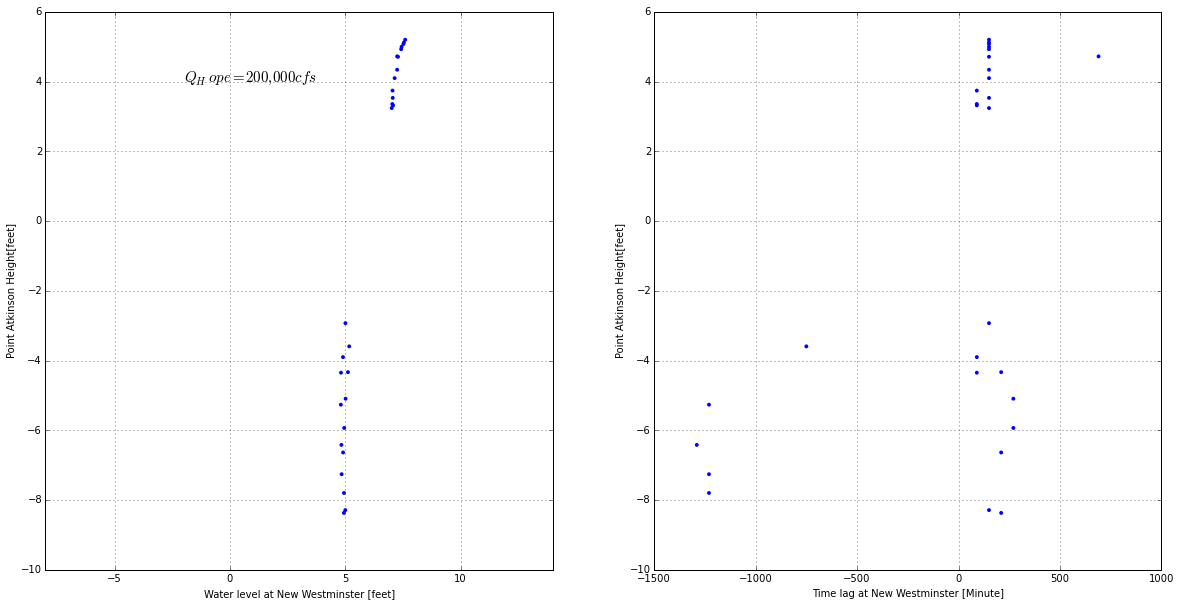

In [23]:
fig = plot_height_time_stn(ssh_model, ssh_obs, time_lag_mod, 'New Westminster')

* The difference of high and low water level(tide amplitude) for New West is 2.8 feet(0.85m). Compared with paper's, which is 4.5 feet(1.3716m). Difference is 0.5m. Ours is too weak, maybe I need to widen the river to make tide propagate?                                                                                           

Mission

In [24]:
## grid cell for Mission is [500, 367]
mima, mimi, tmima, tmimi = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 500, 367,ssh_mod, tt)

In [25]:
##combine both max and min water level for MISIION
ssh_model = []
ssh_model.append(mima)
ssh_model.append(mimi)

In [26]:
delta_max, delta_min = get_time_lag(tmimi, time_min, tmima, time_max)

In [27]:
##combine both time lag for high and low water level at Mission
time_lag_mod = []
time_lag_mod.append(delta_max)
time_lag_mod.append(delta_min)

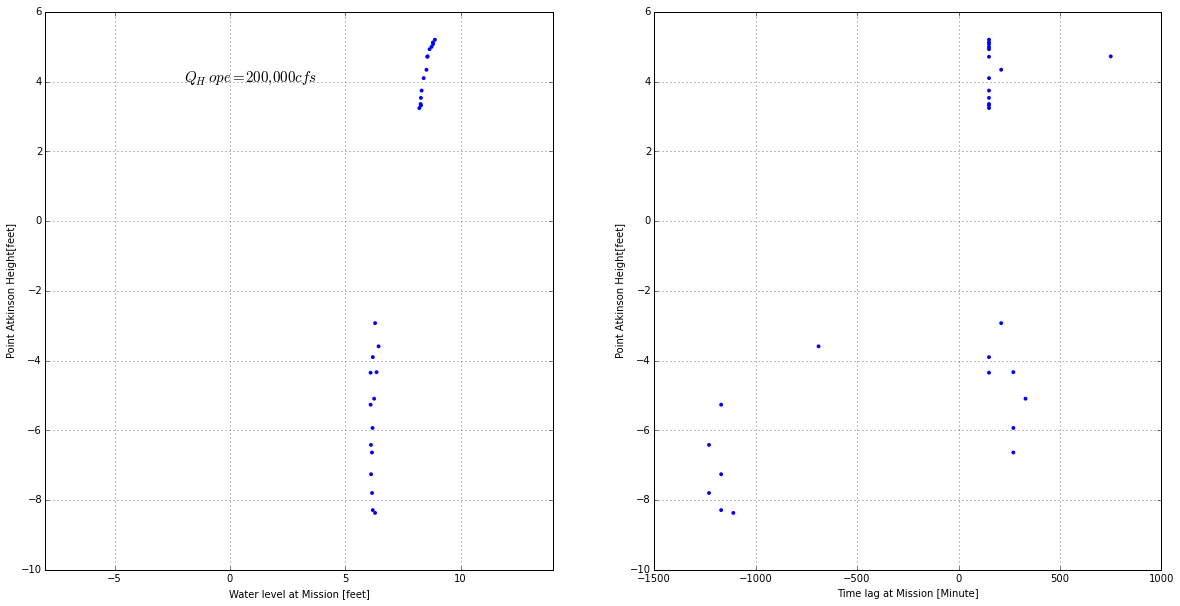

In [28]:
fig = plot_height_time_stn(ssh_model, ssh_obs, time_lag_mod, 'Mission')

* Mission in Ages model show vertical line that are not affected by tide. I will compare it with obs from EC to check.

# Compare with EC data

In [29]:
obs = pd.read_excel('08MH024_HRLY_2015.xls', skiprows = 0)

In [30]:
tt, wl_zoom = zoomin_tide_EC(obs)

In [31]:
obs_max, obs_min, t_max, t_min = find_highlow_tide_EC(tt, wl_zoom)

In [32]:
##combine both max and min water level for MISIION with EC obs
ssh_obs_EC = []
ssh_obs_EC.append(obs_max)
ssh_obs_EC.append(obs_min)

In [33]:
delta_max_obs, delta_min_obs = get_time_lag(t_min, time_min, t_max, time_max)

In [34]:
##combine both time lag for high and low water level at Mission with EC obs
time_lag_obs = []
time_lag_obs.append(delta_max_obs)
time_lag_obs.append(delta_min_obs)

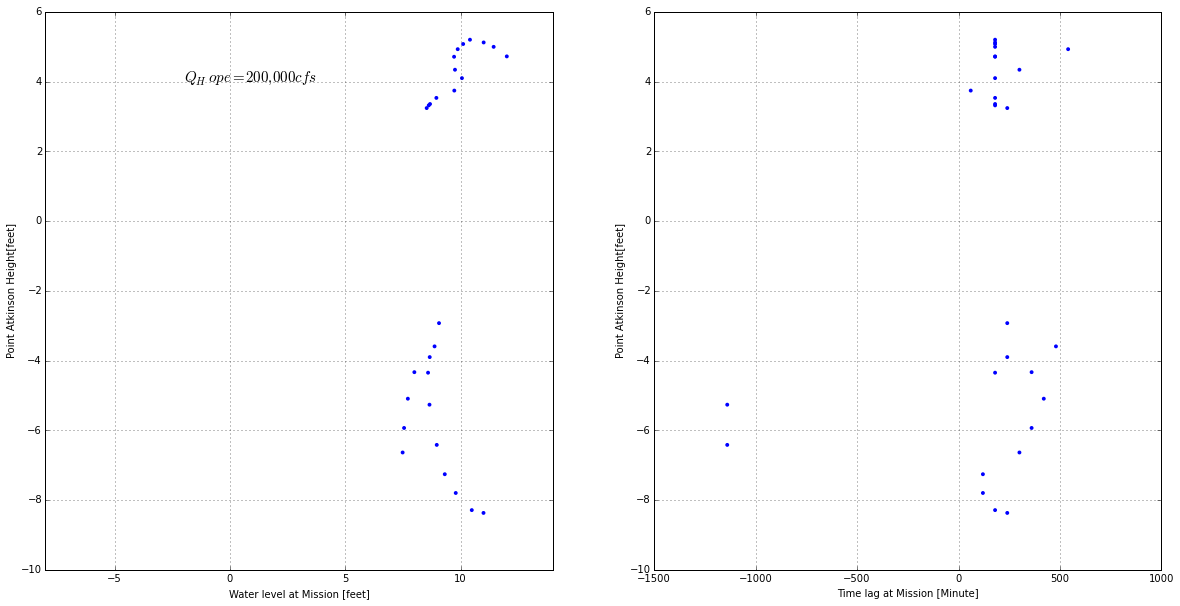

In [35]:
fig = plot_height_time_stn(ssh_obs_EC, ssh_obs, time_lag_obs, 'Mission')

* Amplitude of tidal height at Mission in the model is higher than obs from EC.

Deas Island

In [36]:
## grid cell for Deas Island is [414, 328]
mima, mimi, tmima, tmimi = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 414, 328,ssh_mod, tt)

In [37]:
##combine both max and min water level for DEAS ISLAND
ssh_model = []
ssh_model.append(mima)
ssh_model.append(mimi)

In [38]:
delta_max, delta_min = get_time_lag(tmimi, time_min, tmima, time_max)

In [39]:
##combine both time lag for high and low water level at Deas Island
time_lag_mod = []
time_lag_mod.append(delta_max)
time_lag_mod.append(delta_min)

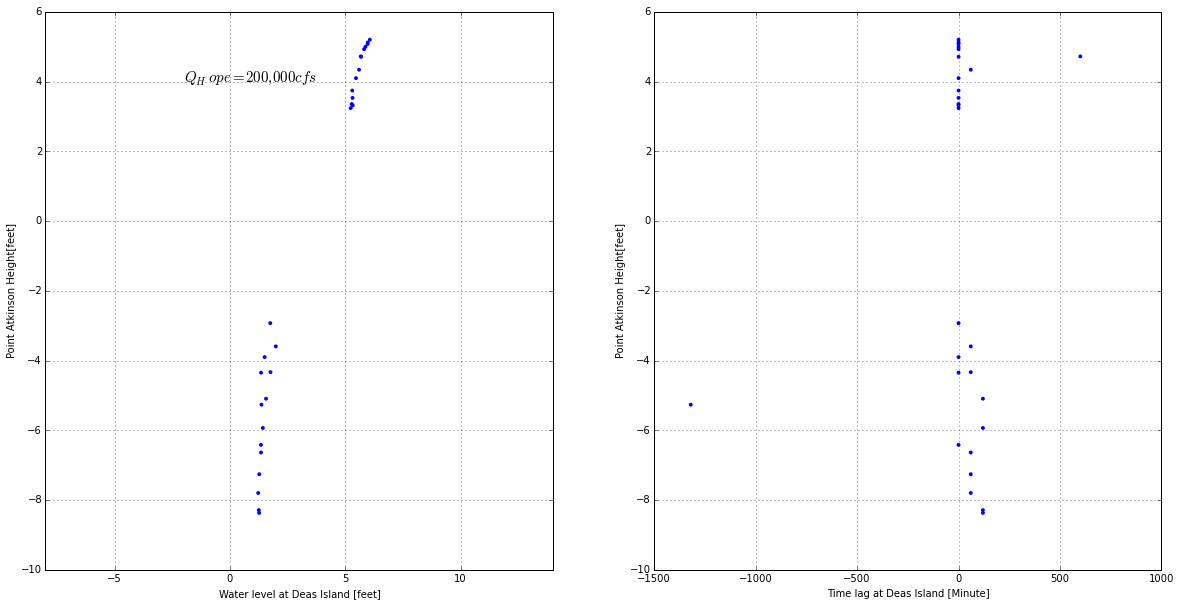

In [40]:
fig = plot_height_time_stn(ssh_model, ssh_obs, time_lag_mod, 'Deas Island')

*  Our Deas Island too far from mouth? Will compare with obs from EC.

Sandheads

In [41]:
## grid cell for Sandheads is [426, 293]
mima, mimi, tmima, tmimi = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 426, 293,ssh_mod, tt)

In [42]:
##combine both max and min water level for SANDHEADS
ssh_model = []
ssh_model.append(mima)
ssh_model.append(mimi)

In [43]:
delta_max, delta_min = get_time_lag(tmimi, time_min, tmima, time_max)

In [44]:
##combine both time lag for high and low water level at Sandheads
time_lag_mod = []
time_lag_mod.append(delta_max)
time_lag_mod.append(delta_min)

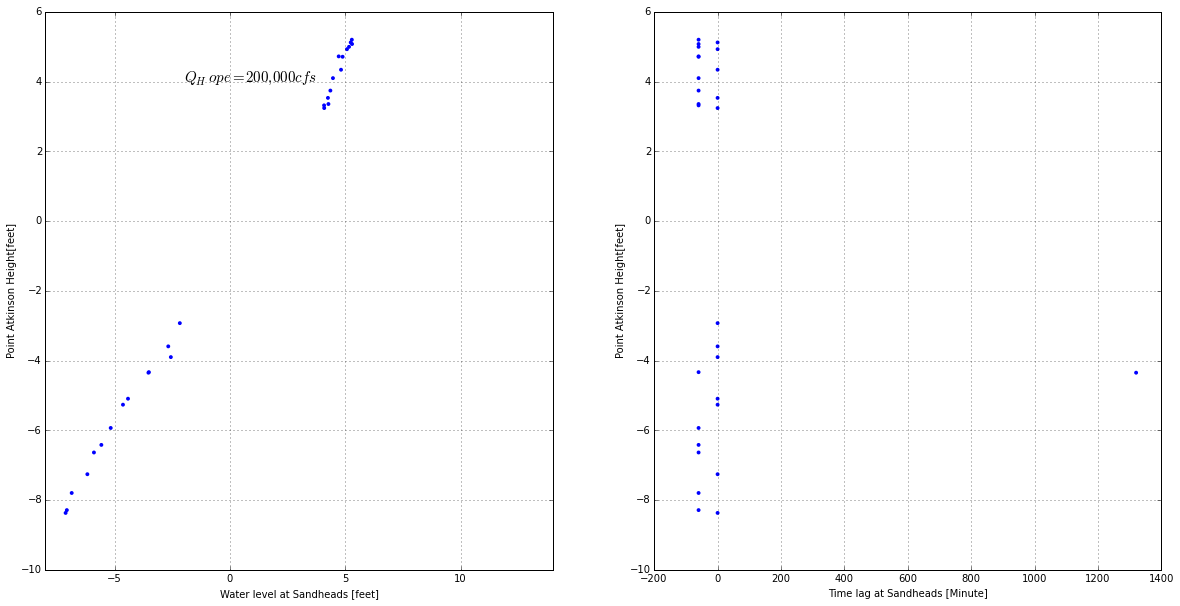

In [45]:
fig = plot_height_time_stn(ssh_model, ssh_obs, time_lag_mod, 'Sandheads')

* Compared with Ages model at Steveston, too high water level for both ebb tide and flood tide.

* Only at New West we got historical data from 1970-1973, with about 0.45m height difference in ebb tide(lower low tidal height). Does this 0.45m difference really matter much for tidal propagation? 